In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d robinreni/signature-verification-dataset

 98% 587M/601M [00:06<00:00, 104MB/s]
100% 601M/601M [00:06<00:00, 97.0MB/s]


In [ ]:
# ! mkdir data
! unzip signature-verification-dataset.zip -d sign_data

Archive:  signature-verification-dataset.zip
  inflating: sign_data/sign_data/sign_data/test/049/01_049.png  
  inflating: sign_data/sign_data/sign_data/test/049/02_049.png  
  inflating: sign_data/sign_data/sign_data/test/049/03_049.png  
  inflating: sign_data/sign_data/sign_data/test/049/04_049.png  
  inflating: sign_data/sign_data/sign_data/test/049/05_049.png  
  inflating: sign_data/sign_data/sign_data/test/049/06_049.png  
  inflating: sign_data/sign_data/sign_data/test/049/07_049.png  
  inflating: sign_data/sign_data/sign_data/test/049/08_049.png  
  inflating: sign_data/sign_data/sign_data/test/049/09_049.png  
  inflating: sign_data/sign_data/sign_data/test/049/10_049.png  
  inflating: sign_data/sign_data/sign_data/test/049/11_049.png  
  inflating: sign_data/sign_data/sign_data/test/049/12_049.png  
  inflating: sign_data/sign_data/sign_data/test/049_forg/01_0114049.PNG  
  inflating: sign_data/sign_data/sign_data/test/049_forg/01_0206049.PNG  
  inflating: sign_data/sign

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm

# test = pd.read_csv("/content/sign_data/sign_data/test_data.csv")
train = pd.read_csv("/content/sign_data/sign_data/train_data.csv")
train.sample(5)

,068/09_068.png,068_forg/03_0113068.PNG,1
525,033/04_033.png,033/03_033.png,0
11233,003/003_19.PNG,003/003_03.PNG,0
805,039/08_039.png,039/06_039.png,0
4028,014/014_08.PNG,014/014_16.PNG,0
5085,012/012_18.PNG,012/012_14.PNG,0


1 denotes for forged pair and 0 denotes for geniune pair of signatures...

In [ ]:
len(train)

23205

In [ ]:
pd = train
train = train[~ train['068/09_068.png'].str.contains("068/")]
test = pd[pd['068/09_068.png'].str.contains("068/")]
len(test)

227

In [ ]:
base_dir ="/content/sign_data/sign_data/train"
img_h, img_w = 28, 56

def process_image(image):
    return image/255

def dataset(base_dir, train):
    sign1 = []
    sign2 = []
    label = []
    sign1path = []
    sign2path = []

    for i in tqdm(range(len(train))):
    # for i in tqdm(range(0, 20000)):

        path1 = train.iloc[i][0]
        path2 = train.iloc[i][1]
        label.append(train.iloc[i][2])

        sign1path.append(path1)  
        sign2path.append(path2)

        img1 = cv2.imread(os.path.join(base_dir, path1), cv2.IMREAD_GRAYSCALE)
        img1 = cv2.resize(img1, (img_h, img_w)) 
        img1 = process_image(img1)
        sign1.append(img1)
        img2 = cv2.imread(os.path.join(base_dir, path2), cv2.IMREAD_GRAYSCALE)
        img2 = cv2.resize(img2, (img_h, img_w)) 
        img2 = process_image(img2)
        sign2.append(img2)

    return np.array(sign1), np.array(sign2), np.array(label).astype('float32'), sign1path, sign2path 


In [ ]:
s1, s2, l, s1path, s2path = dataset(base_dir, train)

In [ ]:
sign1, sign2, label, sign1path, sign2path = s1[:20000], s2[:20000], l[:20000], s1path[:20000], s2path[:20000] 

sign1t, sign2t, labelt, sign1patht, sign2patht = s1[20000:], s2[20000:], l[20000:], s1path[20000:], s2path[20000:] 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils.vis_utils import plot_model

def signature(input_shape):
    left_img=Input(input_shape)
    right_img=Input(input_shape)
 
    model=Sequential()
    model.add(Conv2D(96, (5,5),activation='relu',input_shape=input_shape))
    model.add(BatchNormalization(epsilon=1e-06,  axis=1, momentum=0.9))
    model.add(MaxPooling2D())
    # model.add(Dropout(0.2))
    model.add(Conv2D(128, (3,3), activation='relu',padding="same"))
    model.add(BatchNormalization(epsilon=1e-06,  axis=1, momentum=0.9))
    model.add(MaxPooling2D())
    model.add(Conv2D(96, (3,3), activation='relu',padding="same"))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(256,activation='sigmoid'))
    # model.summary()
    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)
    
    enc_1 = model(left_img)
    enc_2 = model(right_img)
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0]-tensors[1]))
    L1_distance = L1_layer([enc_1,enc_2])
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    
    signature_mod = Model(inputs = [left_img,right_img], outputs = prediction)
    # signature_mod.summary()
    return signature_mod

input_shape = (img_w, img_h, 1)
model = signature(input_shape)    



# compile model using RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(lr=0.00004, rho=0.9, epsilon=1e-08)
model.compile(loss='binary_crossentropy', optimizer=rms, metrics = ['accuracy'])

# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
# callbacks = [
#     EarlyStopping(patience=3, verbose=1),
#     ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
#     ModelCheckpoint('./Weights/signet-bhsig260-{epoch:03d}.h5', verbose=1, save_weights_only=True)
# ]

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=4),
         ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

history = model.fit([sign1,sign2],label, 
                    batch_size = 32,
                    epochs = 20,
                    validation_split = 0.1,
                    callbacks = callbacks,
                    shuffle=True,
                    verbose=2)

Epoch 1/20
563/563 - 7s - loss: 0.6924 - accuracy: 0.5353 - val_loss: 0.6923 - val_accuracy: 0.5775
Epoch 2/20
563/563 - 6s - loss: 0.6436 - accuracy: 0.6158 - val_loss: 0.5211 - val_accuracy: 0.7690
Epoch 3/20
563/563 - 6s - loss: 0.5093 - accuracy: 0.7542 - val_loss: 0.5684 - val_accuracy: 0.5930
Epoch 4/20
563/563 - 6s - loss: 0.4207 - accuracy: 0.8156 - val_loss: 0.4946 - val_accuracy: 0.7155
Epoch 5/20
563/563 - 6s - loss: 0.3545 - accuracy: 0.8524 - val_loss: 0.3752 - val_accuracy: 0.8625
Epoch 6/20
563/563 - 6s - loss: 0.2940 - accuracy: 0.8911 - val_loss: 0.3029 - val_accuracy: 0.9035
Epoch 7/20
563/563 - 6s - loss: 0.2341 - accuracy: 0.9213 - val_loss: 0.3877 - val_accuracy: 0.8400
Epoch 8/20
563/563 - 6s - loss: 0.1836 - accuracy: 0.9446 - val_loss: 0.3536 - val_accuracy: 0.8770
Epoch 9/20
563/563 - 6s - loss: 0.1396 - accuracy: 0.9599 - val_loss: 0.2805 - val_accuracy: 0.8945
Epoch 10/20
563/563 - 6s - loss: 0.0996 - accuracy: 0.9757 - val_loss: 0.2418 - val_accuracy: 0.8960

In [ ]:
model.evaluate([sign1t,sign2t], labelt)

94/94 [==============================] - 1s 6ms/step - loss: 0.1378 - accuracy: 0.9614


[0.13781143724918365, 0.9613834619522095]

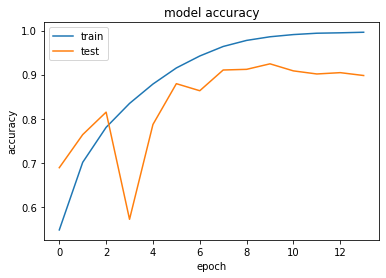

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_dir = '/content/sign_data/sign_data/test'
s1t, s2t, llt, s1patht, s2patht = dataset(base_dir, test)
model.evaluate([s1t,s2t], llt)


8/8 [==============================] - 0s 5ms/step - loss: 0.0112 - accuracy: 1.0000


[0.01116105541586876, 1.0]

In [ ]:
model.predict([s1t,s2t])

array([[0.99925095],
       [0.9997495 ],
       [0.9985222 ],
       [0.99953806],
       [0.99928206],
       [0.99956375],
       [0.99970007],
       [0.9991412 ],
       [0.9998926 ],
       [0.99995804],
       [0.9997954 ],
       [0.99994326],
       [0.9997689 ],
       [0.9999455 ],
       [0.99995744],
       [0.9984388 ],
       [0.9998455 ],
       [0.9999286 ],
       [0.99964523],
       [0.9998903 ],
       [0.99967563],
       [0.9999275 ],
       [0.9999199 ],
       [0.9981371 ],
       [0.99973744],
       [0.999897  ],
       [0.99932575],
       [0.9997826 ],
       [0.9994648 ],
       [0.999881  ],
       [0.99986744],
       [0.99620736],
       [0.99947053],
       [0.99981064],
       [0.99873847],
       [0.99976796],
       [0.9992482 ],
       [0.999793  ],
       [0.9997149 ],
       [0.9992524 ],
       [0.9998776 ],
       [0.9999479 ],
       [0.99968386],
       [0.99991727],
       [0.99975675],
       [0.999941  ],
       [0.9999336 ],
       [0.998

In [ ]:
model.save("sig_trained_model.h5")
model = tf.keras.models.load_model('sig_trained_model.h5')

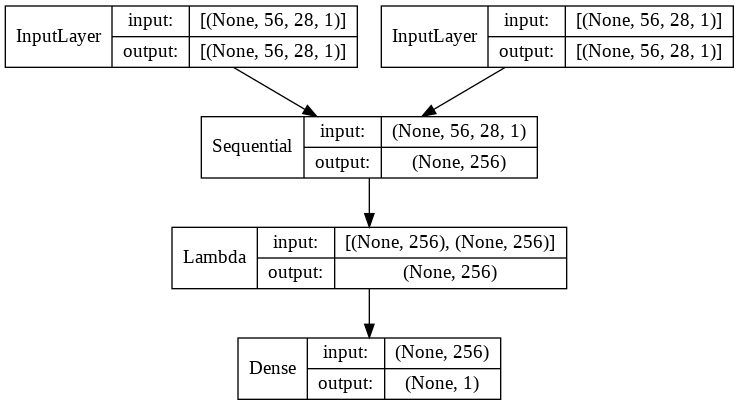

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [ ]:
y = model.predict([sign1t,sign2t])
a=0
for i in range(0,2500):
  # print(labelt[i],"--", np.round(y[i]))
  if ((labelt[i]) != (np.round(y[i]))):
      print(labelt[i],"--", y[i], sign1patht[i], sign2patht[i])
      
      a+=1
a

1.0 -- [0.10272435] 056/02_056.png 056_forg/03_0115056.PNG
1.0 -- [0.06192035] 056/02_056.png 056_forg/02_0105056.PNG
1.0 -- [0.3393423] 056/02_056.png 056_forg/01_0115056.PNG
1.0 -- [0.05321501] 056/08_056.png 056_forg/03_0115056.PNG
1.0 -- [0.05902666] 056/08_056.png 056_forg/02_0105056.PNG
1.0 -- [0.1588077] 056/08_056.png 056_forg/01_0115056.PNG
1.0 -- [0.10382118] 056/09_056.png 056_forg/03_0115056.PNG
1.0 -- [0.04964336] 056/09_056.png 056_forg/02_0105056.PNG
1.0 -- [0.20493859] 056/09_056.png 056_forg/01_0115056.PNG
1.0 -- [0.14077608] 056/10_056.png 056_forg/03_0115056.PNG
1.0 -- [0.05347493] 056/10_056.png 056_forg/02_0105056.PNG
1.0 -- [0.14602448] 056/10_056.png 056_forg/01_0115056.PNG
1.0 -- [0.49679953] 056/10_056.png 056_forg/01_0105056.PNG
1.0 -- [0.04088383] 056/04_056.png 056_forg/03_0115056.PNG
1.0 -- [0.06513325] 056/04_056.png 056_forg/02_0105056.PNG
1.0 -- [0.10412429] 056/04_056.png 056_forg/01_0115056.PNG
1.0 -- [0.1438147] 056/06_056.png 056_forg/03_0115056.PNG


133

In [ ]:
y_pred = model.predict([sign1t,sign2t])

from sklearn.metrics import classification_report

y_pred_bool = np.round(y_pred)
print("classification report")
print(classification_report(labelt, y_pred_bool))

classification report
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95      1538
         1.0       0.97      0.93      0.95      1440

    accuracy                           0.95      2978
   macro avg       0.95      0.95      0.95      2978
weighted avg       0.95      0.95      0.95      2978

